# Building metadata pipelines

In this example, the notion of a "metadata pipeline" is demonstrated:

When processing data, this data can be accompanied by a descriptive MetaData object. It can be an attribute of the object or a namespace variable itself. When a process has a "metadata pipeline", it does not only process a set of data, but also the attached metadata, which always needs to be provided. This requires functions and operators to be slightly adjusted. The below example shows how such a workflow could look like.

> This example uses the package `matplotlib`. It can be installed using `pip install matplotlib` or `pip install <path to pyDuCo>[examples]`

In [1]:
import dublincore as dc
import numpy as np
import matplotlib.pyplot as plt
import os

## Data object

The data object in this simple example is a dataset with an x and an y value. It further has a MetaData object as an attribute.

In [2]:
class Dataset:

    def __init__(self, name: str,  x: np.ndarray):
        # data part
        self.x = x
        self.y = np.zeros_like(x)

        # metadata part
        self.metadata = dc.MetaData(name)
        # here, some example data is stored. It can be extended as needed
        self.metadata.extent = (x.min(), x.max())
        self.metadata.type = "dataset"

    def copy(self):
        # This function creates a copy of the dataset
        other = Dataset("copy of {0}".format(self.metadata.identifier), self.x)
        other.y = self.y

        # metadata pipeline: Also have to process the metadata.
        other.metadata.stock_up(self.metadata)
        other.metadata.relationSource = self.metadata
        return other

    def stretch(self):
        """
            This function stretches the y vector of the dataset in y-direction by a factor of 2
        """
        # process the data
        self.y = 2.0 * self.y

        # metadata pipeline: We have a new step in our process chain
        self.metadata.add_to_term("accrualMethod", "Stretched by 2.0")

Also, any function which takes such a dataset object with metadata attached should access and update the metadata. 

In [3]:
def apply_sinus(dataset: Dataset):
    # process the data
    dataset.y = np.sin(dataset.x)

    # process the metadata
    dataset.metadata.add_to_term("accrualMethod", "Applied Sinus")

def plot_and_export(*args: Dataset):
    fig, ax = plt.subplots()
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    # Every (sufficiently complex) object is described by some MetaData object
    # In this case, also the plot itself.
    plot_meta_data = dc.MetaData("example_plot")  # Add more metadata as suitable

    for d in args:
        # process the data of each dataset
        p = ax.plot(d.x, d.y)

        # process the metadata of all involved objects
        plot_meta_data.addRelationReferences(d.metadata)
        d.metadata.relationIsReferencedBy = plot_meta_data
    
    # Having the metadata actually comes handy in the script...
    ax.legend([d.metadata.identifier for d in args])

    # Export data and metadata
    fig.show()
    fig.savefig(os.path.join("metadata_pipeline", "example_plot.png"))
    dc.metadata2obsidian(plot_meta_data, "metadata_pipeline", "--obs")      

We can now write some code and watch our data auto-documenting itself! 

/var/folders/y_/559shxdj25gf1pyln9_ktp2r0000gn/T/ipykernel_92729/2109810443.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


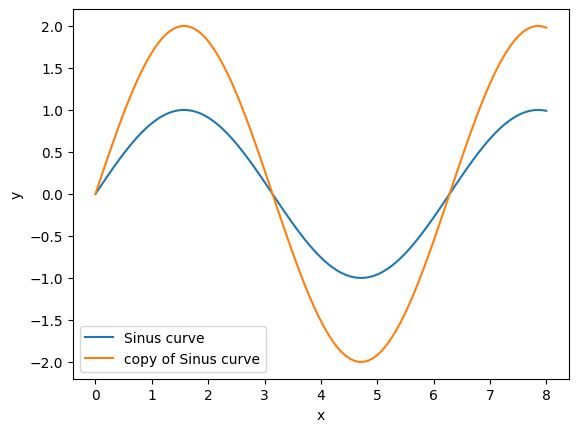

In [4]:
x = np.linspace(0.0, 8.0, 100)

# Create and process the first dataset
my_data = Dataset("Sinus curve", x)
apply_sinus(my_data)

# Create and process the second dataset. It is a copy and shall later reference its source
my_data2 = my_data.copy()
my_data2.stretch()

# Plot and save the data
plot_and_export(my_data, my_data2)